In [3]:
import requests
import json
import datetime
import pandas as pd
import numpy as np
import re
import os
import random
import urllib3
import time
import matplotlib
import nltk
import jieba

from ckiptagger import data_utils, construct_dictionary, WS, POS, NER

from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from datetime import datetime
from tqdm.notebook import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score,train_test_split, validation_curve, cross_val_predict
from sklearn.metrics import roc_curve, accuracy_score, recall_score, confusion_matrix,f1_score

tqdm_notebook.pandas()

path = '../data/TW/'
ckiptagger_path = "//Users/user/ckiptagger"

In [4]:
df = pd.read_csv(path + 'TW_news.csv')
df = df.drop(columns=["index", "sub_source"])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/TW/TW_news.csv'

## preprocess

In [7]:
print(df.source.value_counts())
df["source_num"] = df.source.map({'ltn': 1, 'central': 0, 'cti': -1})
print(df.source_num.value_counts())

ltn        6387
cti        4269
central     962
Name: source, dtype: int64
 1    6387
-1    4269
 0     962
Name: source_num, dtype: int64


In [8]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\（", "", string)
    string = re.sub(r"\）", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\『", "", string)
    string = re.sub(r"\』", "", string)
    string = re.sub(r"\「", "", string)
    string = re.sub(r"\」", "", string)
    string = re.sub(r"\：", "", string)
    string = re.sub(r"\；", "", string)
    string = re.sub(r"\。", "", string)
    string = re.sub(r"\，", "", string)
    string = re.sub(r"\、", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"\？", "", string)
    string = re.sub(r"\〔", "", string)
    string = re.sub(r"\〕", "", string)
    string = re.sub(r"\／", "", string)
    string = re.sub(r"\.", "", string)
    string = re.sub(r"\記者", "", string)
    string = re.sub(r"\報導", "", string)
    string = re.sub(r"\請繼續往下閱讀", "", string)   
    string = re.sub(r"'", "", string)
    return string.strip().lower()

In [9]:

df['content'] = df.content.progress_apply(clean_str)


  0%|          | 0/11618 [00:00<?, ?it/s]

### slice the characters to words

In [10]:
ws = WS(ckiptagger_path)
word_sliced = ws(df.content)

2023-05-08 17:36:48.648752: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-05-08 17:36:48.685857: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7feb377909c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-08 17:36:48.685877: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [11]:

df["content"] = [" ".join(s) for s in tqdm(word_sliced)]


  0%|          | 0/11618 [00:00<?, ?it/s]

In [16]:
def write_list_to_file(lst, filename):
    with open(filename, 'w') as file:
        for item in tqdm(lst):
            file.write(str(item) + '\n')



In [17]:

write_list_to_file(word_sliced, path + 'ws_TW.txt')

## train models

### functions

In [18]:
def undersamples(df):
    # Count the number of observations for each source
    source_counts = df['source'].value_counts()

    # Find the minimum count among the sources
    min_count = source_counts.min()

    # Subset the data to include only observations with the minimum count for each source
    subset_df = df.groupby('source').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
    return subset_df

In [19]:
def get_xy(df):
    x = df['content'].tolist()
    y = df['source_num'].tolist()
    
    stopwordset= set(stopwords.words('english'))
    morestop={'cnn', 'keyword', 'state', 'said'}
    stopwordset= list(stopwordset.union(morestop))

    vect = TfidfVectorizer(stop_words=stopwordset)
    X = vect.fit_transform(x)
    Y = np.array(y)
    
    return (X, Y)


In [20]:
def generate_evaluate(df):

    (X, y) = get_xy(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    
    evalute_dict = {}
    # create logistic regression model
    # Fit logistic regression model
   
    evalute_dict['knn'] = {}
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    evalute_dict['knn']['preds'] = knn.predict(X_test)
    evalute_dict['knn']['acc'] = accuracy_score(y_test, evalute_dict['knn']['preds'])
    evalute_dict['knn']['f1'] = f1_score(y_test, evalute_dict['knn']['preds'], average='weighted')
    print(f"K Neighbors Classifier: accuracy {evalute_dict['knn']['acc']}/ f1 {evalute_dict['knn']['f1']}" )

    
    # Fit Multinomial Naive Bayes model
    evalute_dict['mnb'] = {}
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    evalute_dict['mnb']['preds'] = mnb.predict(X_test)
    evalute_dict['mnb']['acc'] = accuracy_score(y_test, evalute_dict['mnb']['preds'])
    evalute_dict['mnb']['f1'] = f1_score(y_test, evalute_dict['mnb']['preds'],  average='weighted')
    print(f"Multinomial Naive Bayes: accuracy {evalute_dict['mnb']['acc']}/ f1 {evalute_dict['mnb']['f1']}" )
    
    evalute_dict['svm'] = {}
    svm = SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)
    evalute_dict['svm']['preds'] = svm.predict(X_test)
    evalute_dict['svm']['acc'] = accuracy_score(y_test, evalute_dict['svm']['preds'])
    evalute_dict['svm']['f1'] = f1_score(y_test, evalute_dict['svm']['preds'], average='weighted')
    print(f"Support Vector Machine: accuracy {evalute_dict['svm']['acc']}/ f1 {evalute_dict['svm']['f1']}" )

    # Decision Tree
    evalute_dict['tree'] = {}
    tree = DecisionTreeClassifier(random_state=1234)
    tree.fit(X_train, y_train)
    evalute_dict['tree']['preds'] = tree.predict(X_test)
    evalute_dict['tree']['acc'] = accuracy_score(y_test,evalute_dict['tree']['preds'])
    evalute_dict['tree']['f1'] = f1_score(y_test, evalute_dict['tree']['preds'], average='weighted')
    print(f"Decision Tree: accuracy {evalute_dict['tree']['acc']}/ f1 {evalute_dict['tree']['f1']}" )
   
    return evalute_dict 

### whole

In [21]:
df_dict = generate_evaluate(df)
df_result = pd.DataFrame(df_dict).T
df_result.to_csv(path+ 'tw_result.csv')

K Neighbors Classifier: accuracy 0.6962134251290878/ f1 0.6911489772026836
Multinomial Naive Bayes: accuracy 0.6222030981067126/ f1 0.522360651754961
Support Vector Machine: accuracy 0.6858864027538726/ f1 0.6324095417109867
Decision Tree: accuracy 0.8128227194492255/ f1 0.8129613539134045


In [22]:
df_subset = undersamples(df)
sub_dict = generate_evaluate(df_subset)
sub_result = pd.DataFrame(sub_dict).T
sub_result.to_csv(path+ 'sub_result.csv')

K Neighbors Classifier: accuracy 0.6089965397923875/ f1 0.5961585620836751
Multinomial Naive Bayes: accuracy 0.7560553633217993/ f1 0.7472446722447881
Support Vector Machine: accuracy 0.7231833910034602/ f1 0.7277878656206317
Decision Tree: accuracy 0.7716262975778547/ f1 0.7679082325537702


### get keywords

In [23]:
dpp_df = df[df['keyword_dpp']==1]
dpp_subset = undersamples(dpp_df)


In [24]:
dpp_dict = generate_evaluate(dpp_df)
dpp_result = pd.DataFrame(dpp_dict).T
dpp_result.to_csv(path+ 'dpp_result.csv')

K Neighbors Classifier: accuracy 0.693564862104188/ f1 0.6921595337827657
Multinomial Naive Bayes: accuracy 0.7129724208375894/ f1 0.674129861418139
Support Vector Machine: accuracy 0.7558733401430031/ f1 0.7473724235039667
Decision Tree: accuracy 0.7916241062308478/ f1 0.7914791033140148


In [25]:
dpp_sub_dict = generate_evaluate(dpp_subset)
dpp_sub_result = pd.DataFrame(dpp_sub_dict).T
dpp_sub_result.to_csv(path+ 'dpp_sub_result.csv')

K Neighbors Classifier: accuracy 0.6078431372549019/ f1 0.5914946956145716
Multinomial Naive Bayes: accuracy 0.7529411764705882/ f1 0.7464939520302842
Support Vector Machine: accuracy 0.6941176470588235/ f1 0.6927575953458306
Decision Tree: accuracy 0.7372549019607844/ f1 0.730381020842179


In [26]:
kmt_df = df[df['keyword_kmt']==1]
kmt_subset = undersamples(kmt_df)


In [27]:
kmt_dict = generate_evaluate(kmt_df)
kmt_result = pd.DataFrame(kmt_dict).T
kmt_result.to_csv(path+ 'kmt_result.csv')

K Neighbors Classifier: accuracy 0.6888315041962556/ f1 0.6862121166610551
Multinomial Naive Bayes: accuracy 0.6262104583602324/ f1 0.5380523841697535
Support Vector Machine: accuracy 0.6701097482246611/ f1 0.6030176766566738
Decision Tree: accuracy 0.8121368624919303/ f1 0.8118577663878619


In [28]:
kmt_sub_dict = generate_evaluate(kmt_subset)
kmt_sub_result = pd.DataFrame(kmt_sub_dict).T
kmt_sub_result.to_csv(path+ 'kmt_sub_result.csv')

K Neighbors Classifier: accuracy 0.6368715083798883/ f1 0.6228995146352111
Multinomial Naive Bayes: accuracy 0.7486033519553073/ f1 0.7354702877045135
Support Vector Machine: accuracy 0.7737430167597765/ f1 0.7747638003607777
Decision Tree: accuracy 0.7681564245810056/ f1 0.7627839860425765


In [29]:
han_df = df[df['keyword_han']==1]
han_subset = undersamples(han_df)

han_dict = generate_evaluate(han_df)
han_result = pd.DataFrame(han_dict).T
han_result.to_csv(path+ 'han_result.csv')

han_sub_dict = generate_evaluate(han_subset)
han_sub_result = pd.DataFrame(han_sub_dict).T
han_sub_result.to_csv(path+ 'han_sub_result.csv')

K Neighbors Classifier: accuracy 0.7116654438738078/ f1 0.7079878978996208
Multinomial Naive Bayes: accuracy 0.7263389581804842/ f1 0.6893658911053573
Support Vector Machine: accuracy 0.7109317681584739/ f1 0.6869167462033382
Decision Tree: accuracy 0.8239178283198826/ f1 0.8238550261979709
K Neighbors Classifier: accuracy 0.7078189300411523/ f1 0.7005557612346008
Multinomial Naive Bayes: accuracy 0.7037037037037037/ f1 0.6879557793206984
Support Vector Machine: accuracy 0.6666666666666666/ f1 0.6021459965901803
Decision Tree: accuracy 0.7860082304526749/ f1 0.7785533415432693


In [30]:
tasi_df = df[df['keyword_tsai']==1]
tasi_subset = undersamples(tasi_df)

tasi_dict = generate_evaluate(tasi_df)
tasi_result = pd.DataFrame(tasi_dict).T
tasi_result.to_csv(path+ 'tasi_result.csv')

tasi_sub_dict = generate_evaluate(tasi_subset)
tasi_sub_result = pd.DataFrame(tasi_sub_dict).T
tasi_sub_result.to_csv(path+ 'tasi_sub_result.csv')

K Neighbors Classifier: accuracy 0.7062391681109186/ f1 0.7010566906803947
Multinomial Naive Bayes: accuracy 0.6403812824956673/ f1 0.5604011192315143
Support Vector Machine: accuracy 0.6681109185441941/ f1 0.6051943361969969
Decision Tree: accuracy 0.7902946273830156/ f1 0.7900991601314897
K Neighbors Classifier: accuracy 0.6460176991150443/ f1 0.6350395313333913
Multinomial Naive Bayes: accuracy 0.7699115044247787/ f1 0.76020626413886
Support Vector Machine: accuracy 0.7035398230088495/ f1 0.699827678914696
Decision Tree: accuracy 0.7522123893805309/ f1 0.7462518831056673


In [31]:
election_df = df[df['keyword_election']==1]
election_subset = undersamples(election_df)

election_dict = generate_evaluate(election_df)
election_result = pd.DataFrame(election_dict).T
election_result.to_csv(path+ 'election_result.csv')

election_sub_dict = generate_evaluate(election_subset)
election_sub_result = pd.DataFrame(election_sub_dict).T
election_sub_result.to_csv(path+ 'election_sub_result.csv')

K Neighbors Classifier: accuracy 0.6678321678321678/ f1 0.6606763142054749
Multinomial Naive Bayes: accuracy 0.5944055944055944/ f1 0.4601332798192025
Support Vector Machine: accuracy 0.6826923076923077/ f1 0.5977507684095016
Decision Tree: accuracy 0.7840909090909091/ f1 0.7837905280565749
K Neighbors Classifier: accuracy 0.6563307493540051/ f1 0.6415240929710417
Multinomial Naive Bayes: accuracy 0.7493540051679587/ f1 0.7385803545729619
Support Vector Machine: accuracy 0.7209302325581395/ f1 0.7216717722606342
Decision Tree: accuracy 0.7545219638242894/ f1 0.7497408852097984


### get sources

#### cti vs ltn

In [32]:
def get_2news(data, except_num):
    return data[data.source_num!=except_num]

In [33]:
cti_ltn = get_2news(df, 0)
cti_ltn_sub = get_2news(df_subset, 0)

In [34]:
cti_ltn_dict = generate_evaluate(cti_ltn)
cti_ltn_result = pd.DataFrame(cti_ltn_dict).T
cti_ltn_result.to_csv(path+ 'cti_ltn_result.csv')

K Neighbors Classifier: accuracy 0.725609756097561/ f1 0.7166559264363898
Multinomial Naive Bayes: accuracy 0.6838649155722326/ f1 0.609212188219585
Support Vector Machine: accuracy 0.6791744840525328/ f1 0.6184408658976812
Decision Tree: accuracy 0.8348968105065666/ f1 0.8350054846229278


In [35]:
cti_ltn_sub_dict = generate_evaluate(cti_ltn_sub)
cti_ltn_sub_result = pd.DataFrame(cti_ltn_sub_dict).T
cti_ltn_sub_result.to_csv(path+ 'cti_ltn_sub_result.csv')

K Neighbors Classifier: accuracy 0.6519480519480519/ f1 0.651004821736529
Multinomial Naive Bayes: accuracy 0.7558441558441559/ f1 0.7551146722626282
Support Vector Machine: accuracy 0.7012987012987013/ f1 0.6965370894989664
Decision Tree: accuracy 0.825974025974026/ f1 0.825990463345494


#### cti vs neutral

In [36]:
cti_neu = get_2news(df, 1)
cti_neu_sub = get_2news(df_subset, 1)

In [37]:
cti_neu_dict = generate_evaluate(cti_neu)
cti_neu_result = pd.DataFrame(cti_neu_dict).T
cti_neu_result.to_csv(path+ 'cti_neu_result.csv')

K Neighbors Classifier: accuracy 0.8624641833810889/ f1 0.8720365243260741
Multinomial Naive Bayes: accuracy 0.8299904489016237/ f1 0.7538355261603952
Support Vector Machine: accuracy 0.9713467048710601/ f1 0.9702797152984914
Decision Tree: accuracy 0.9503342884431709/ f1 0.9517285394980873


In [38]:
cti_neu_sub_dict = generate_evaluate(cti_neu_sub)
cti_neu_sub_result = pd.DataFrame(cti_neu_sub_dict).T
cti_neu_sub_result.to_csv(path+ 'cti_neu_sub_result.csv')

K Neighbors Classifier: accuracy 0.7766233766233767/ f1 0.7712081857536403
Multinomial Naive Bayes: accuracy 0.8389610389610389/ f1 0.8353220031879878
Support Vector Machine: accuracy 0.9064935064935065/ f1 0.9056563482374161
Decision Tree: accuracy 0.8961038961038961/ f1 0.8955861601295466


### ltn vs neutral

In [39]:
ltn_neu = get_2news(df, -1)
ltn_neu_sub = get_2news(df_subset, -1)

In [40]:
ltn_neu_dict = generate_evaluate(ltn_neu)
ltn_neu_result = pd.DataFrame(ltn_neu_dict).T
ltn_neu_result.to_csv(path+ 'ltn_neu_result.csv')

K Neighbors Classifier: accuracy 0.8965986394557823/ f1 0.9019643096226306
Multinomial Naive Bayes: accuracy 0.8755102040816326/ f1 0.8173969043547777
Support Vector Machine: accuracy 0.9741496598639455/ f1 0.972994500853043
Decision Tree: accuracy 0.9530612244897959/ f1 0.9541417069656272


In [41]:
ltn_neu_sub_dict = generate_evaluate(ltn_neu_sub)
ltn_neu_sub_result = pd.DataFrame(ltn_neu_sub_dict).T
ltn_neu_sub_result.to_csv(path+ 'ltn_neu_sub_result.csv')

K Neighbors Classifier: accuracy 0.7480519480519481/ f1 0.7446840491137167
Multinomial Naive Bayes: accuracy 0.8233766233766234/ f1 0.818793401720231
Support Vector Machine: accuracy 0.9064935064935065/ f1 0.9055595658645339
Decision Tree: accuracy 0.8753246753246753/ f1 0.8742748776647081


## analysis result

In [5]:
# generate mean
def get_avg(data):

    data.loc['mean'] = [None, data['acc'].mean(), data['f1'].mean()]
    return data

### read in data

In [7]:
## keywords

df_result = get_avg(pd.read_csv(path+ 'tw_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
dpp_result =get_avg( pd.read_csv(path+ 'dpp_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
kmt_result = get_avg( pd.read_csv(path+ 'kmt_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
han_result = get_avg(pd.read_csv(path+ 'han_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
tsai_result = get_avg(pd.read_csv(path+ 'tsai_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
election_result = get_avg( pd.read_csv(path+ 'election_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))

sub_result = get_avg( pd.read_csv(path+ 'sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
dpp_sub_result = get_avg( pd.read_csv(path+ 'dpp_sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
kmt_sub_result = get_avg( pd.read_csv(path+ 'kmt_sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
han_sub_result = get_avg( pd.read_csv(path+ 'han_sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
tsai_sub_result = get_avg( pd.read_csv(path+ 'tsai_sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
election_sub_result = get_avg (pd.read_csv(path+ 'election_sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))



df_result.head()

,preds,acc,f1
model,,,
knn,[ 1 -1 -1 ... -1 -1 1],0.696213,0.691149
mnb,[ 1 -1 1 ... 1 1 1],0.622203,0.522361
svm,[ 1 1 -1 ... 1 1 1],0.685886,0.632410
tree,[ 1 -1 -1 ... 1 -1 -1],0.812823,0.812961
mean,NaN,0.704281,0.664720


In [8]:
## source

cti_neu_result = get_avg( pd.read_csv(path+ 'cti_neu_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
ltn_neu_result = get_avg( pd.read_csv(path+ 'ltn_neu_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
cti_ltn_result =get_avg( pd.read_csv(path+ 'cti_ltn_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))

cti_neu_sub_result = get_avg( pd.read_csv(path+ 'cti_neu_sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
ltn_neu_sub_result = get_avg(pd.read_csv(path+ 'ltn_neu_sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))
cti_ltn_sub_result = get_avg( pd.read_csv(path+ 'cti_ltn_sub_result.csv').rename(columns={"Unnamed: 0": "model"}).set_index('model'))

cti_neu_sub_result.head()
                                                                                                                   

,preds,acc,f1
model,,,
knn,[-1 0 0 0 0 -1 0 0 0 0 -1 -1 0 -1 -1 ...,0.776623,0.771208
mnb,[-1 0 0 0 0 -1 0 0 0 0 -1 -1 0 0 -1 ...,0.838961,0.835322
svm,[-1 -1 0 0 -1 -1 0 0 0 0 -1 -1 0 0 -1 ...,0.906494,0.905656
tree,[-1 -1 0 0 0 -1 0 0 0 0 -1 -1 0 0 -1 ...,0.896104,0.895586
mean,NaN,0.854545,0.851943


### functions

In [37]:
def show_bar(data):
    # create the bar plot
    name = data.attrs["name"] 
    print(name)
    bar_width = 0.35
    index = range(len(data.columns))
    
    print(data.loc['acc'])
    
    fig, ax = plt.subplots()
    ax.bar(index, data.loc['acc'],  bar_width , color=['blue', 'orange', 'green', 'red'])
    # ax = .plot(kind='bar', figsize=(12, 10))
    ax.set_ylabel('Accuracy')
    # ax.set_title(f'Accuracy of {name} model')
    
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(data.columns)
    ax.figsize=(12,10)
    # plt.figure(figsize=(12,10))
    
    plt.show()
    

In [23]:


def bars_2data(df1, df2):
    name = df1.attrs["name"] 
    print(name)
    # create a bar plot comparing the 'acc' values of the two data frames
    fig, ax = plt.subplots()
    bar_width = 0.35
    opacity = 0.8

    index = range(len(df1.columns))
    rects1 = ax.bar(index, df1.loc['acc'], bar_width, alpha=opacity, color='b', label='Whole Dataset')
    rects2 = ax.bar([i + bar_width for i in index], df2.loc['acc'], bar_width, alpha=opacity, color='g', label='Undersample')

    ax.set_xlabel('Columns')
    ax.set_ylabel('Accuracy')
    # ax.set_title(f'Accuracy of {name} model')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(df1.columns)
    ax.legend()
    ax.figsize=(20,8)

    # plt.figure(figsize=(20,8))
#     plt.tight_layout()
    plt.show()

### source comparison|

In [27]:
models_list = []

models = ['knn', 'mnb', 'svm', 'tree', 'mean']

for m in models:
    model_df = pd.DataFrame()
    model_df.attrs['name'] = m
    
    model_df['whole data'] = df_result.loc[m, ['acc', 'f1']]
    model_df['cti_ltn'] = cti_ltn_result.loc[m, ['acc', 'f1']]
    model_df['ltn_neu'] = ltn_neu_result.loc[m, ['acc', 'f1']]
    model_df['cti_neu'] = cti_neu_result.loc[m, ['acc', 'f1']]
    
    models_list.append(model_df)

In [28]:
sub_models_list = []

models = ['knn', 'mnb', 'svm', 'tree', 'mean']

for m in models:
    model_df = pd.DataFrame()
    model_df.attrs['name'] = m
    
    model_df['whole data'] = sub_result.loc[m, ['acc', 'f1']]
    model_df['cti_ltn'] = cti_ltn_sub_result.loc[m, ['acc', 'f1']]
    model_df['ltn_neu'] = ltn_neu_sub_result.loc[m, ['acc', 'f1']]
    model_df['cti_neu'] = cti_neu_sub_result.loc[m, ['acc', 'f1']]
    
    sub_models_list.append(model_df)

In [29]:
sub_models_list[0]

,whole data,cti_ltn,ltn_neu,cti_neu
acc,0.608997,0.651948,0.748052,0.776623
f1,0.596159,0.651005,0.744684,0.771208


### keyword comparison

In [30]:
keyword_models_list = []

models = ['knn', 'mnb', 'svm', 'tree']

for m in models:
    model_df = pd.DataFrame()
    model_df.attrs['name'] = m
    
    model_df['whole data'] = df_result.loc[m, ['acc', 'f1']]
    model_df['Tsai'] = tsai_result.loc[m, ['acc', 'f1']]
    model_df['Han'] = han_result.loc[m, ['acc', 'f1']]
    model_df['KMT'] = kmt_result.loc[m, ['acc', 'f1']]
    model_df['DPP'] = dpp_result.loc[m, ['acc', 'f1']]
    model_df['election'] = election_result.loc[m, ['acc', 'f1']]
    
    keyword_models_list.append(model_df)

In [31]:
keyword_sub_models_list = []

models = ['knn', 'mnb', 'svm', 'tree', 'mean']

for m in models:
    model_df = pd.DataFrame()
    model_df.attrs['name'] = m
    
    model_df['whole data'] = sub_result.loc[m, ['acc', 'f1']]
    model_df['Tsai'] = tsai_sub_result.loc[m, ['acc', 'f1']]
    model_df['Han'] = han_sub_result.loc[m, ['acc', 'f1']]
    model_df['KMT'] = kmt_sub_result.loc[m, ['acc', 'f1']]
    model_df['DPP'] = dpp_sub_result.loc[m, ['acc', 'f1']]
    model_df['election'] = election_sub_result.loc[m, ['acc', 'f1']]
    
    keyword_sub_models_list.append(model_df)

### show graphs

knn
whole data    0.608997
Tsai          0.553398
Han           0.707819
KMT           0.636872
DPP           0.607843
election      0.656331
Name: acc, dtype: object


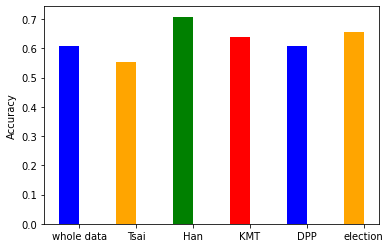

mnb
whole data    0.756055
Tsai          0.640777
Han           0.703704
KMT           0.748603
DPP           0.752941
election      0.749354
Name: acc, dtype: object


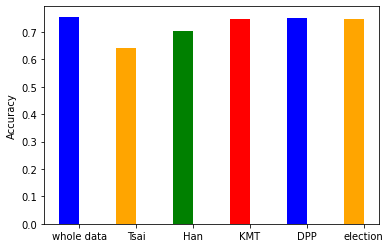

svm
whole data    0.723183
Tsai          0.456311
Han           0.666667
KMT           0.773743
DPP           0.694118
election       0.72093
Name: acc, dtype: object


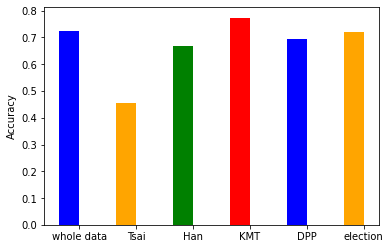

tree
whole data    0.771626
Tsai          0.805825
Han           0.786008
KMT           0.768156
DPP           0.737255
election      0.754522
Name: acc, dtype: object


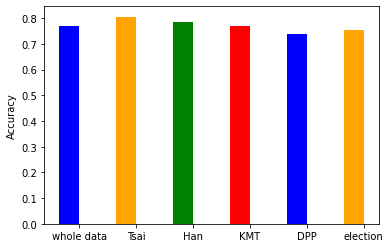

mean
whole data    0.714965
Tsai          0.614078
Han           0.716049
KMT           0.731844
DPP           0.698039
election      0.720284
Name: acc, dtype: object


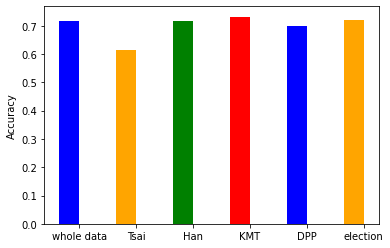

In [38]:
for i in range(5):
    show_bar(keyword_sub_models_list[i])

knn


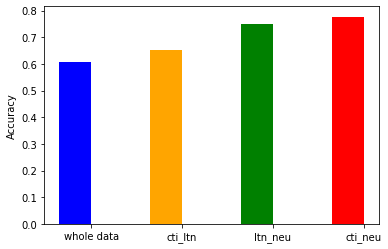

mnb


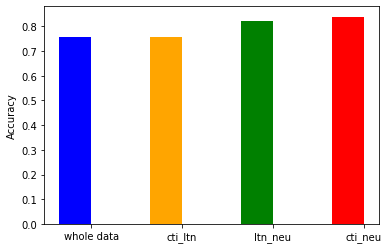

svm


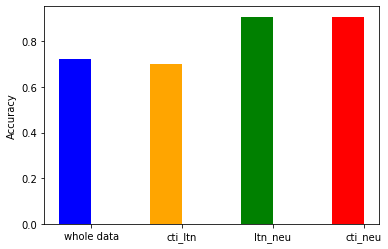

tree


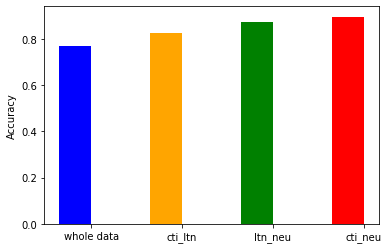

mean


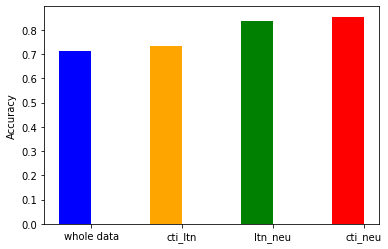

In [35]:
for i in range(5):
    show_bar(sub_models_list[i])

knn


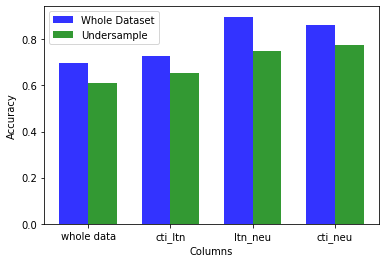

mnb


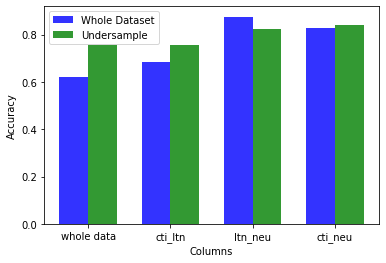

svm


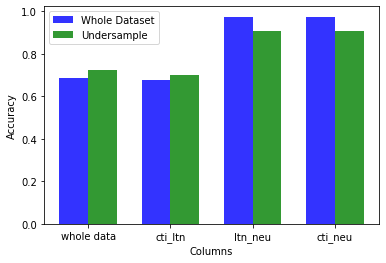

tree


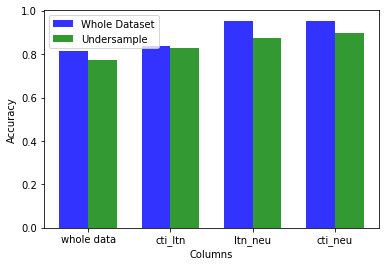

mean


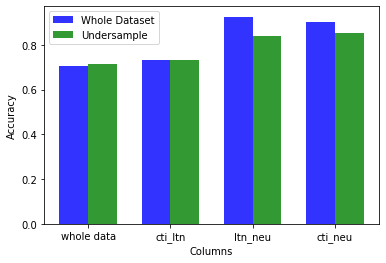

In [36]:
for i in range(5):

    bars_2data(models_list[i], sub_models_list[i])

In [ ]:
for i in range(4):

    bars_2data(keyword_models_list[i], keyword_sub_models_list[i])

In [ ]:

for i in range(4):

    show_bar(keyword_models_list[i])